In [1]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from estimate_exponential_arrivals import load_minimal_df, estimate_once, auto_horizon_T

In [2]:
# --- 2. Load data ---
df = pd.read_csv("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")
print(df.head())
print(df.columns)

  exchange    symbol         timestamp   local_timestamp  asks[0].price  \
0  binance  DOGEUSDT  1735689601703988  1735689601703988        0.31601   
1  binance  DOGEUSDT  1735689601974000  1735689601975707        0.31601   
2  binance  DOGEUSDT  1735689602074000  1735689602075995        0.31601   
3  binance  DOGEUSDT  1735689602274000  1735689602275736        0.31601   
4  binance  DOGEUSDT  1735689602374000  1735689602375702        0.31601   

   asks[0].amount  bids[0].price  bids[0].amount  asks[1].price  \
0          126244          0.316           87917        0.31602   
1          126244          0.316           87917        0.31602   
2          126244          0.316           87917        0.31602   
3          115444          0.316           87917        0.31602   
4          115444          0.316           87917        0.31602   

   asks[1].amount  ...  bids[22].price  bids[22].amount  asks[23].price  \
0           27345  ...         0.31578            82614         0.31624

In [3]:
# Ensure consistent column names
df.columns = [c.strip().lower() for c in df.columns]

# Convert timestamps if in microseconds
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
    
print(df.head())

  exchange    symbol                  timestamp   local_timestamp  \
0  binance  DOGEUSDT 2025-01-01 00:00:01.703988  1735689601703988   
1  binance  DOGEUSDT 2025-01-01 00:00:01.974000  1735689601975707   
2  binance  DOGEUSDT 2025-01-01 00:00:02.074000  1735689602075995   
3  binance  DOGEUSDT 2025-01-01 00:00:02.274000  1735689602275736   
4  binance  DOGEUSDT 2025-01-01 00:00:02.374000  1735689602375702   

   asks[0].price  asks[0].amount  bids[0].price  bids[0].amount  \
0        0.31601          126244          0.316           87917   
1        0.31601          126244          0.316           87917   
2        0.31601          126244          0.316           87917   
3        0.31601          115444          0.316           87917   
4        0.31601          115444          0.316           87917   

   asks[1].price  asks[1].amount  ...  bids[22].price  bids[22].amount  \
0        0.31602           27345  ...         0.31578            82614   
1        0.31602           30507  

<Figure size 640x480 with 0 Axes>

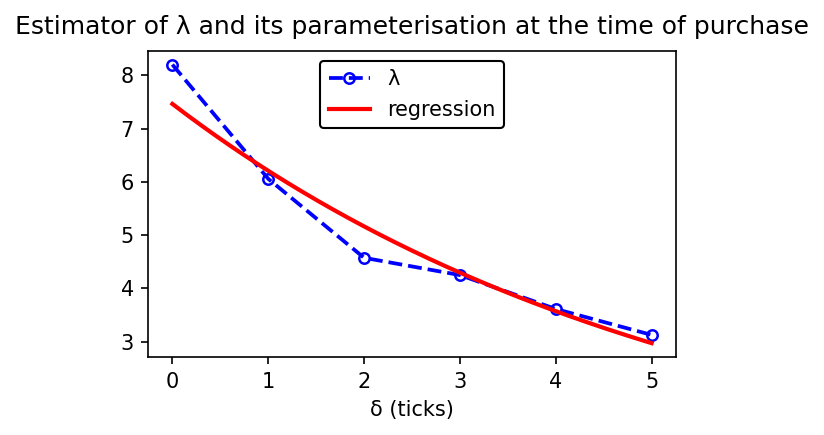

<Figure size 640x480 with 0 Axes>

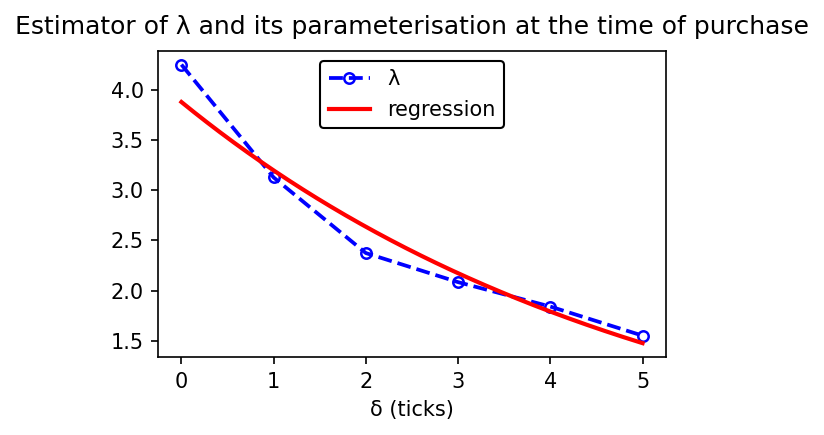

,side,delta,lambda_hat,uncensored,exposure_seconds,tick,window
0,ask,0,8.201402,708,86.326701,0.00001,global
1,ask,1,6.057090,523,86.345087,0.00001,global
2,ask,2,4.574004,395,86.357594,0.00001,global
3,ask,3,4.249631,367,86.360433,0.00001,global
4,ask,4,3.612518,312,86.366358,0.00001,global
5,ask,5,3.126070,270,86.370420,0.00001,global
6,bid,0,4.249619,367,86.360674,0.00001,global
7,bid,1,3.126078,270,86.370193,0.00001,global
8,bid,2,2.373316,205,86.377044,0.00001,global
9,bid,3,2.083831,180,86.379381,0.00001,global


,side,A_hat,k_hat,used_points,tick,window
0,ask,7.463065,0.184191,6,0.00001,global
1,bid,3.877114,0.193084,6,0.00001,global


In [4]:
# 1) Load your data (CSV with columns like asks[0].price, bids[0].price + a timestamp)
core = load_minimal_df(Path("D:/Documents/CLS/thesis/MM_sandbox/binance_book_snapshot_25_2025-01-01_DOGEUSDT.csv")).sort_values("__ts").reset_index(drop=True)

# 2) Choose settings
deltas = [0,1,2,3,4,5]    # in ticks
T = auto_horizon_T(core["__ts"])  # right-censoring horizon (sec)
tick_override = None      # or e.g., 0.01 if you know the tick
outdir = Path("out_demo"); outdir.mkdir(exist_ok=True)

# 3) Estimate (once, globally)
rates, fit = estimate_once(core, deltas, T, tick_override, make_plots=True, outdir=outdir, label_suffix="global", show_plots=True)

# 4) Inspect
display(rates.head(10))
display(fit)

In [5]:
# Midprice = (best_bid + best_ask) / 2
df['best_bid'] = df['bids[0].price']
df['best_ask'] = df['asks[0].price']
df['midprice'] = (df['best_bid'] + df['best_ask']) / 2

In [6]:
# If tick size known, set it here (you can estimate it later)
tick_size = 0.0001  # example

# Compute δ for each level
for i in range(5):  # use top 5 levels as example
    df[f'bid_delta_{i}'] = (df['midprice'] - df[f'bids[{i}].price']) / tick_size
    df[f'ask_delta_{i}'] = (df[f'asks[{i}].price'] - df['midprice']) / tick_size

In [7]:
# Approximate arrival events by price movements
df['bid_price_change'] = df['best_bid'].diff().abs() > 0
df['ask_price_change'] = df['best_ask'].diff().abs() > 0

# Estimate fill rates as frequency of changes per time unit
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df['bid_arrival_rate'] = df['bid_price_change'] / df['time_diff']
df['ask_arrival_rate'] = df['ask_price_change'] / df['time_diff']

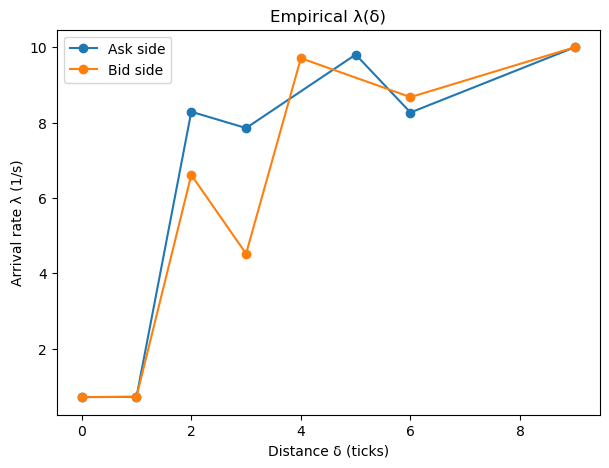

In [8]:
# 1) infer tick (robust-ish)
def infer_tick_from_prices(prices: pd.Series) -> float:
    p = np.sort(prices.dropna().unique())
    diffs = np.diff(p)
    diffs = diffs[diffs > 0]
    return float(np.round(np.quantile(diffs, 0.05), 8)) if len(diffs) else np.nan

tick_bid = infer_tick_from_prices(df['bids[0].price'])
tick_ask = infer_tick_from_prices(df['asks[0].price'])
tick = np.nanmin([tick_bid, tick_ask])

# 2) convert to integer ticks (≥0)
df['delta_ask_ticks'] = np.maximum(0, np.rint((df['asks[0].price'] - df['midprice']) / tick)).astype(int)
df['delta_bid_ticks'] = np.maximum(0, np.rint((df['midprice'] - df['bids[0].price']) / tick)).astype(int)

# 3) approximate arrival rates (price-change proxy)
df = df.sort_values('timestamp').reset_index(drop=True)
df['dt'] = df['timestamp'].diff().dt.total_seconds().replace(0, np.nan)
df['bid_arrival_rate'] = (df['bids[0].price'].diff().abs() > 0).astype(int) / df['dt']
df['ask_arrival_rate'] = (df['asks[0].price'].diff().abs() > 0).astype(int) / df['dt']

ask_group = (df[['delta_ask_ticks','ask_arrival_rate']]
             .dropna()
             .groupby('delta_ask_ticks', as_index=False)
             .agg(lambda_mean=('ask_arrival_rate','mean')))

bid_group = (df[['delta_bid_ticks','bid_arrival_rate']]
             .dropna()
             .groupby('delta_bid_ticks', as_index=False)
             .agg(lambda_mean=('bid_arrival_rate','mean')))

plt.figure(figsize=(7,5))
if not ask_group.empty:
    plt.plot(ask_group['delta_ask_ticks'], ask_group['lambda_mean'], marker='o', label='Ask side')
if not bid_group.empty:
    plt.plot(bid_group['delta_bid_ticks'], bid_group['lambda_mean'], marker='o', label='Bid side')
plt.xlabel('Distance δ (ticks)')
plt.ylabel('Arrival rate λ (1/s)')
plt.title('Empirical λ(δ)')
plt.legend()
plt.show()

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def exp_model(delta, A, k):
    return A * np.exp(-k * delta)

# --- build integer tick distances (assumes df has best_bid/best_ask/mid and tick) ---
df = df.sort_values('timestamp').reset_index(drop=True)

# arrival proxies (avoid dt=0)
df['dt'] = df['timestamp'].diff().dt.total_seconds().replace(0, np.nan)
df['ask_arrival_rate'] = (df['asks[0].price'].diff().abs() > 0).astype(int) / df['dt']
df['bid_arrival_rate'] = (df['bids[0].price'].diff().abs() > 0).astype(int) / df['dt']

# integer tick deltas
df['delta_ask_ticks'] = np.maximum(0, np.rint((df['asks[0].price'] - df['midprice']) / tick)).astype(int)
df['delta_bid_ticks'] = np.maximum(0, np.rint((df['midprice'] - df['bids[0].price']) / tick)).astype(int)

# group by delta; use counts as weights
ask_g = (df[['delta_ask_ticks','ask_arrival_rate']]
         .dropna()
         .groupby('delta_ask_ticks', as_index=False)
         .agg(lambda_mean=('ask_arrival_rate','mean'),
              n=('ask_arrival_rate','size')))

bid_g = (df[['delta_bid_ticks','bid_arrival_rate']]
         .dropna()
         .groupby('delta_bid_ticks', as_index=False)
         .agg(lambda_mean=('bid_arrival_rate','mean'),
              n=('bid_arrival_rate','size')))

# choose one side to fit (e.g., ask)
g = ask_g.rename(columns={'delta_ask_ticks':'delta','lambda_mean':'lambda'})
g = g[(g['lambda']>0) & np.isfinite(g['lambda'])]

if len(g) < 3:
    raise ValueError("Not enough (δ, λ) points to fit. Increase bins/levels/time window.")

x = g['delta'].astype(float).values
y = g['lambda'].astype(float).values
w = g['n'].astype(float).values  # optional weights (more obs -> higher weight)

# good initial guesses and bounds
A0 = y.max()
k0 = 0.1
popt, pcov = curve_fit(exp_model, x, y, p0=(A0, k0), bounds=([0, 0], [np.inf, np.inf]))
A_hat, k_hat = popt
print(f"Estimated A = {A_hat:.6g}, k = {k_hat:.6g}")


Estimated A = 6.52218, k = 3.16909e-16
